In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Contamination Mixture Model

First let's download some synthetic data $(x_i,y_i)$, where $\{x_i\}$ are known with negligible uncertainty, and $\{y_i\}$ values have variable uncertainties $\{\sigma_{yi}\}$.

In [2]:
!wget -q --no-check-certificate https://astrostatistics.psu.edu/datasets/censor.dat

In [5]:
df = pd.read_csv('censor.dat', delim_whitespace=True)
df

,Star,Type,Teff,Ind_Be,logN_Be,sig_Be,Ind_Li,logN_Li
0,BD-103166,1,5320,1,0.50,NaN,1,NaN
1,HD_6434,1,5835,1,1.08,0.10,0,0.80
2,HD_9826,1,6212,1,1.05,0.13,1,2.55
3,HD_10647,1,6143,1,1.19,0.10,1,2.80
4,HD_10697,1,5641,1,1.31,0.13,1,1.96
...,...,...,...,...,...,...,...,...
63,HD_85117,2,6167,1,1.11,0.11,1,2.64
64,HD_189567,2,5765,1,1.06,0.10,0,0.82
65,HD_192310,2,5069,0,0.60,NaN,0,0.20
66,HD_211415,2,5890,1,1.12,0.10,1,1.92


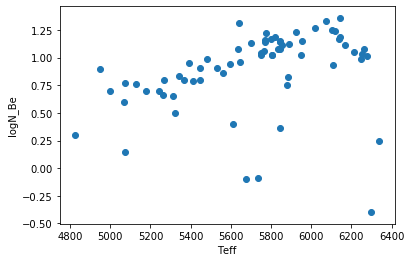

In [7]:
plt.scatter(df.Teff, df.logN_Be)
plt.xlabel(df.Teff.name)
plt.ylabel(df.logN_Be.name);

To deal with outliers we need to define a *generative model* for both the good data (foreground) and the bad (background).  Each datum can either be from the foreground or the background, and since we don't know *a priori*, we need to introduce discrete parameters $q_i$, where $q_i=0$ indicates datum $i$ is background, and $q_i=1$ if foreground.  We'll assign a prior probability $P_b$ of each data point being bad.  Since we need a generative model for the background, let's assume it's normally distributed with mean and variance $Y_b$ and $V_b$.

We have now added $N+3$ extra parameters $(\{q_i\}_{i=1}^N, P_b, Y_b, V_b)$ to deal with outliers, and the likelihood takes the form

$$
\mathcal{L} = p\left(\{y_i\}_{i=1}^N|m,b,\{q_i\}_{i=1}^N,Y_b,V_b,I\right)
$$

or, broken down into foreground and background

$$
\mathcal{L} = \prod_i \left[p_\mathrm{fg}(\{y_i\}|m,b,I)\right]^{q_i} \left[p_\mathrm{bg}(\{y_i\}|Y_b, V_b, I)\right]^{1-q_i},
$$

where

$$
p_\mathrm{fg} = \frac{1}{\sqrt{2\pi\sigma_{yi}^2}} \exp \left(-\frac{(y_i - mx_i - b)^2}{2\sigma_{yi}^2}\right) \\
p_\mathrm{bg} = \frac{1}{\sqrt{2\pi(V_b + \sigma_{yi}^2})} \exp \left(-\frac{(y_i - Y_b)^2}{2(V_b+\sigma_{yi}^2)}\right) 
$$

Since we are specifying a probability $P_b$ of each data point being an outlier, we need to incorporate this binomial probability in our prior

$$
p(m,b,\{q_i\},P_b,Y_b,V_b|I) = p(\{q_i\}|P_b,I)p(m,b,P_b,Y_b,V_b|I)
$$

where $p(\{q_i\}|P_b,I)$ is the binomial probability

$$
p(\{q_i\}|P_b,I) = \prod_i \left(1 - P_b\right)^{q_i}P_b^{1-q_i}
$$

## Foreground-only Model

In [8]:
import pymc3 as pm

In [13]:
with pm.Model() as linear_model:
    # Priors for unknown model parameters
    b = pm.Normal('intercept', mu=0, sd=10)
    m = pm.Normal('slope', mu=0, sd=10)
    σ = pm.HalfNormal('noise_sd', sd=10)

    μ = b + m * df.Teff

    # Likelihood (sampling distribution) of observations
    obs = pm.Normal('obs', mu=μ, sd=σ, observed=df.logN_Be)

In [14]:
with linear_model:
    trace = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise_sd, slope, intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:37<00:00, 739.57draws/s]


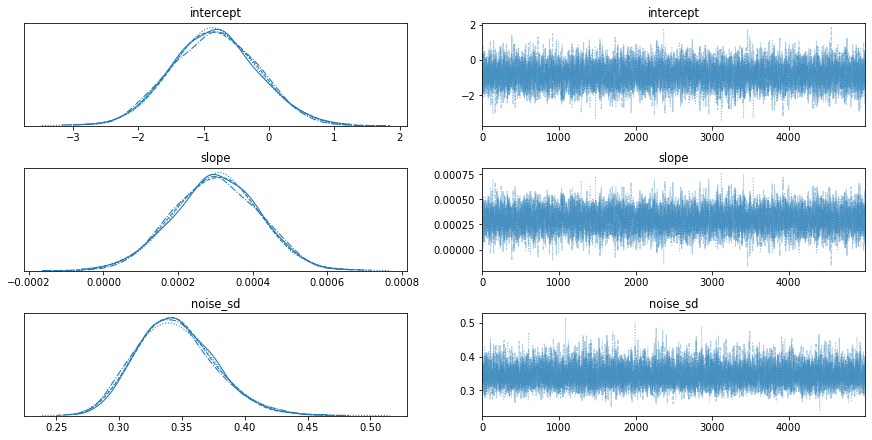

In [15]:
pm.traceplot(trace);

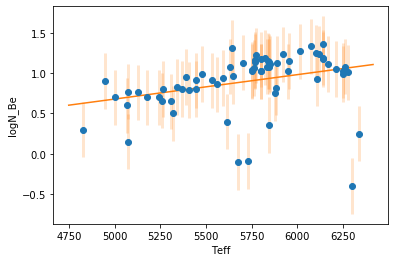

In [21]:
m = np.median(trace['slope'])
b = np.median(trace['intercept'])
σ = np.median(trace['noise_sd'])

plt.scatter(df.Teff, df.logN_Be, zorder=99)
plt.errorbar(df.Teff, df.logN_Be, yerr=σ, linewidth=0, elinewidth=3, color='C1', alpha=0.2)
plt.xlabel(df.Teff.name)
plt.ylabel(df.logN_Be.name)
xlow, xhigh = plt.xlim()
xs = np.linspace(xlow, xhigh, 100)

plt.plot(xs, m*xs + b, color='C1');

## Foreground and Background Model

In [44]:
with pm.Model() as linear_model_w_outliers:
    # Foreground model
    b = pm.Normal('intercept', mu=0, sd=10, testval=-1)
    m = pm.Normal('slope', mu=0, sd=1, testval=0.003)
    σ_fg = pm.HalfNormal('noise_sd', sd=1)

    μ_fg = b + m * df.Teff
    
    # Background model
    μ_bg = pm.Normal('mean_b', mu=.5, sd=100)
    σ_bg = pm.HalfNormal('sd_b', sd=10)
    p_bg = pm.Beta('Pb', alpha=1, beta=1)
    
    # Define the foreground/background parameters latent variables
    category = pm.Categorical('foreground', p=pm.math.stack([p_bg, 1-p_bg]), shape=len(df), testval=1)

    # Use switches to assign normal distribution properties to each point based on latent variables
    μ = pm.math.switch(pm.math.eq(category, 0), μ_bg, μ_fg)
    σ = pm.math.switch(pm.math.eq(category, 0), σ_bg, σ_fg)
    
    # Likelihood
    obs = pm.Normal('obs', mu=μ, sd=σ, observed=df.logN_Be)

In [45]:
with linear_model_w_outliers:
    start = pm.find_MAP()
    trace = pm.sample(5000, start=start, tune=2000)

logp = -85.257, ||grad|| = 5.4113e+05: 100%|██████████| 30/30 [00:00<00:00, 1703.27it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [Pb, sd_b, mean_b, noise_sd, slope, intercept]
>BinaryGibbsMetropolis: [foreground]
Sampling 4 chains, 32 divergences: 100%|██████████| 28000/28000 [01:52<00:00, 249.49draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


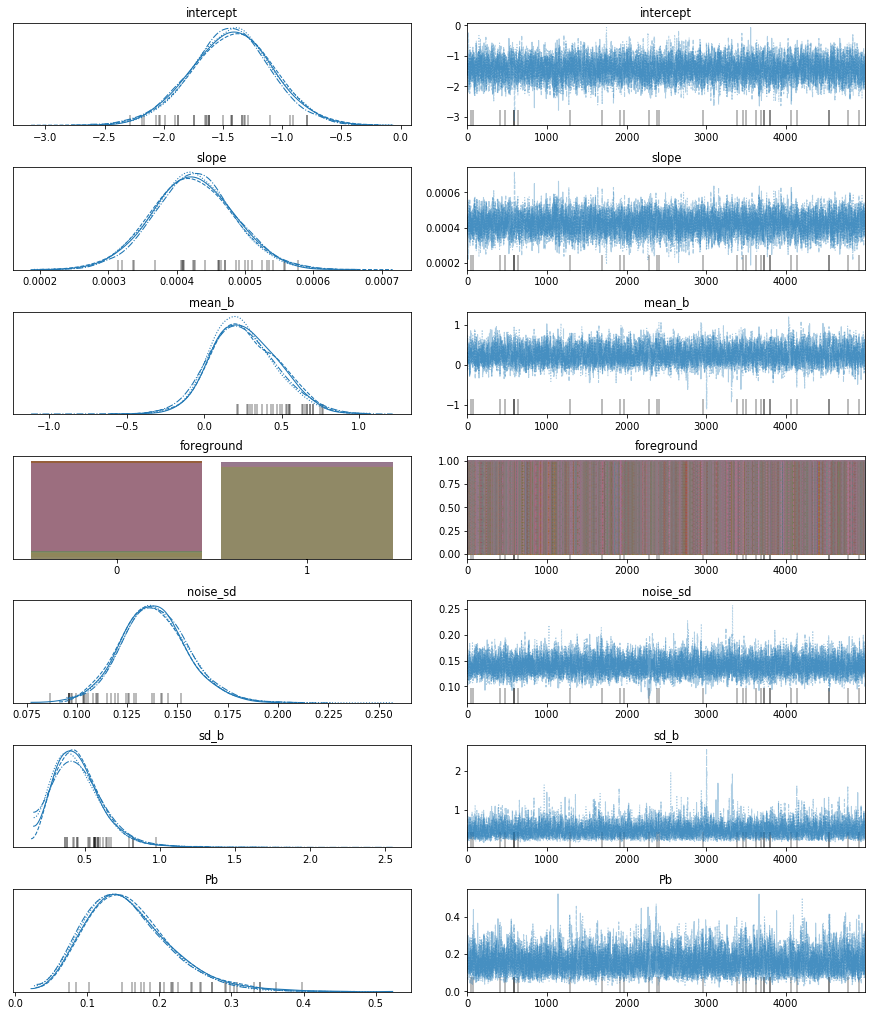

In [46]:
pm.traceplot(trace);

Let's take a look at the distribution probabilities of each point being in the foreground.

(0, 1)

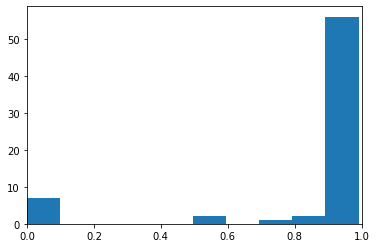

In [47]:
plt.hist(np.mean(trace['foreground'], axis=0))
plt.xlim(0, 1)

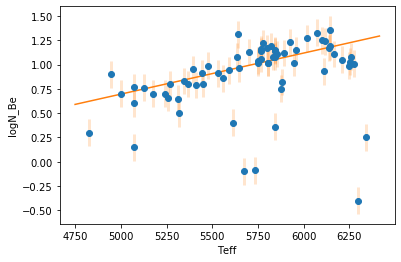

In [49]:
m = np.median(trace['slope'])
b = np.median(trace['intercept'])
σ = np.median(trace['noise_sd'])

plt.scatter(df.Teff, df.logN_Be, zorder=99)
plt.errorbar(df.Teff, df.logN_Be, yerr=σ, linewidth=0, elinewidth=3, color='C1', alpha=0.2)
plt.xlabel(df.Teff.name)
plt.ylabel(df.logN_Be.name)
xlow, xhigh = plt.xlim()
xs = np.linspace(xlow, xhigh, 100)

plt.plot(xs, m*xs + b, color='C1');

Let's highlight the data deterimined to be in the foreground with high confidence, by changing the color of the data that were determined to have <1% probability of being in the foreground.

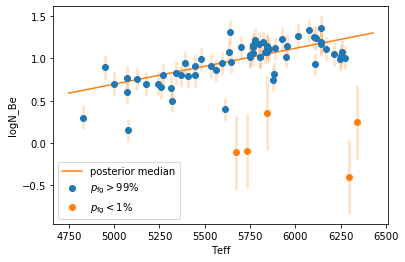

In [53]:
rejected = np.mean(trace['foreground'], axis=0) < .01

m = np.median(trace['slope'])
b = np.median(trace['intercept'])
σ = np.median(trace['noise_sd'])
σbg = np.median(trace['sd_b'])

plt.scatter(df.Teff[~rejected], df.logN_Be[~rejected], zorder=99, label=r"$p_\mathrm{fg} > 99\%$")
plt.scatter(df.Teff[rejected], df.logN_Be[rejected], zorder=99, label=r"$p_\mathrm{fg} < 1\%$")
plt.errorbar(df.Teff[~rejected], df.logN_Be[~rejected], yerr=σ, linewidth=0, elinewidth=3, color='C1', alpha=0.2)
plt.errorbar(df.Teff[rejected], df.logN_Be[rejected], yerr=σbg, linewidth=0, elinewidth=3, color='C1', alpha=0.2)
plt.xlabel(df.Teff.name)
plt.ylabel(df.logN_Be.name)
xlow, xhigh = plt.xlim()
xs = np.linspace(xlow, xhigh, 100)

plt.plot(xs, m*xs + b, color='C1', label='posterior median');
plt.legend(loc='lower left');

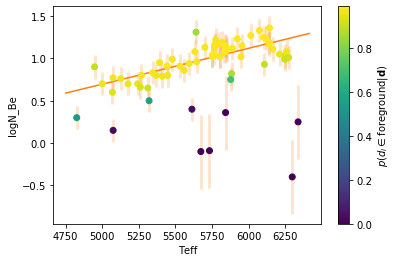

In [57]:
pforeground = np.mean(trace['foreground'], axis=0)

m = np.median(trace['slope'])
b = np.median(trace['intercept'])
σ = np.median(trace['noise_sd'])

plt.scatter(df.Teff, df.logN_Be, c=pforeground, zorder=99)
plt.errorbar(df.Teff[~rejected], df.logN_Be[~rejected], yerr=σ, linewidth=0, elinewidth=3, color='C1', alpha=0.2)
plt.errorbar(df.Teff[rejected], df.logN_Be[rejected], yerr=σbg, linewidth=0, elinewidth=3, color='C1', alpha=0.2)
plt.xlabel(df.Teff.name)
plt.ylabel(df.logN_Be.name)
xlow, xhigh = plt.xlim()
xs = np.linspace(xlow, xhigh, 100)

plt.plot(xs, m*xs + b, color='C1', label='posterior median');
cb = plt.colorbar()
cb.set_label(r'$p(d_i\in \mathrm{foreground}|\mathbf{d})$');